Here we perform a check on DE dataset to confirm choice of loss function for our data.

In [6]:
import os
import re
import pandas as pd
import numpy as np
import subprocess
from utils.helper import extract_metrics_from_output, convert_results_into_df

# 1. Test for Informer

In [2]:
# Paths to files and data
data_path = os.getcwd() + "/datasets/"

script_path = "./PatchTST-main/PatchTST_supervised/run_longExp.py"

# Arguments that will be used also for file names
model = "Informer"
dataset = 'DE_data.csv'
losses = ["MSE", "RMSE", "MAE"]
country = dataset[:2]

log_dir = f"logs/loss_choice"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

log_file_path = f"{log_dir}/{model}_{country}.log"

In [3]:
# Dynamic variables
pred_lens = ["24", "96", "168"]
seq_len = "96"
lr = "0.0001"
itr = 2  
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

informer_results = []

with open(log_file_path, "w") as log_file:
    for loss in losses:
        statement_1 = f"\n=== Starting experiments for loss function: {loss} ===\n"
        log_file.write(statement_1)
        print(statement_1)  # Print to .ipynb output cell

        for pred_len in pred_lens:
            statement_2 = f"\n=== Starting experiments for pred_len: {pred_len} ===\n"
            log_file.write(statement_2)
            print(statement_2) 
            model_id = f"{country}_{seq_len}_{pred_len}_loss_choice_for_{country}"

            # Arguments for the command
            command = f"""
            python {script_path} \
              --random_seed 2021 \
              --is_training 1 \
              --root_path "{data_path}" \
              --data_path "{dataset}" \
              --model_id {model_id} \
              --model "{model}" \
              --data "custom" \
              --features M \
              --seq_len {seq_len} \
              --label_len 5 \
              --pred_len {pred_len} \
              --e_layers 2 \
              --d_layers 1 \
              --factor 5 \
              --enc_in 5 \
              --dec_in 5 \
              --c_out 5 \
              --des 'Exp' \
              --train_epochs 10 \
              --patience 3 \
              --overlapping_windows \
              --loss_fnc "{loss}" \
              --itr {itr} --batch_size 32 --learning_rate "{lr}"
            """

            # Run the command and capture the output
            process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)

            # Capture the output in real-time
            output = []
            for line in process.stdout:
                output.append(line)
                print(line, end='')  # Print in the .ipynb cell
                log_file.write(line)  # Write to the log file

            # Wait for the process to complete
            process.wait()

            # Join all the output lines into a single string
            output_str = "".join(output)

            # Extract metrics for each iteration
            iteration_metrics = extract_metrics_from_output(output, itr)

            # Log the extracted metrics and save them
            for iteration, metrics in enumerate(iteration_metrics, start=1):
                log_file.write(f"\nExtracted Metrics for {country}, pred_len={pred_len}, iteration={iteration}:\n")
                log_file.write(f"MSE: {metrics[0]}, RMSE: {metrics[1]}, MAE: {metrics[2]}, RSE: {metrics[3]}\n")

                # Append the results to the informer_results list
                informer_results.append({
                    'Loss_function': loss,
                    'Pred_len': pred_len,
                    'Iteration': iteration,
                    'MSE': metrics[0],
                    'RMSE': metrics[1],
                    'MAE': metrics[2],
                    'RSE': metrics[3]
                })



=== Starting experiments for loss function: MSE ===

=== Starting experiments for pred_len: 24 ===
Args in experiment:
Namespace(random_seed=2021, is_training=1, model_id='DE_96_24_loss_choice_for_DE', model='Informer', data='custom', root_path='/vol/cs-hu/riabchuv/my_work/datasets/', data_path='DE_data.csv', features='M', target='OT', freq='h', checkpoints='./checkpoints/', overlapping_windows=True, seq_len=96, label_len=5, pred_len=24, inverse=False, loss_fnc='MSE', fc_dropout=0.05, head_dropout=0.0, patch_len=16, stride=8, padding_patch='end', revin=1, affine=0, subtract_last=0, decomposition=0, kernel_size=25, individual=0, embed_type=0, enc_in=5, dec_in=5, c_out=5, d_model=512, n_heads=8, e_layers=2, d_layers=1, d_ff=2048, moving_avg=25, factor=5, distil=True, dropout=0.05, embed='timeF', activation='gelu', output_attention=False, do_predict=False, num_workers=10, itr=2, train_epochs=10, batch_size=32, patience=3, learning_rate=0.0001, des='Exp', lradj='type3', pct_start=0.3, use

In [6]:
path_dir = './dataset_results'
csv_name = 'informer_loss_functions_results.csv'

# Convert the results into a DataFrame and save as CSV
informer_df = convert_results_into_df(informer_results, path_dir, csv_name)
informer_df.round(4)

MSE    RMSE     MAE     RSE
Loss_function Iteration Pred_len                                
MSE           1         24        0.4846  0.6961  0.4748  0.5509
              2         24        0.4871  0.6979  0.4672  0.5524
              1         96        0.8256  0.9086  0.6690  0.7206
              2         96        0.8442  0.9188  0.6719  0.7287
              1         168       0.8689  0.9321  0.6895  0.7384
              2         168       0.9266  0.9626  0.7018  0.7626
RMSE          1         24        0.5057  0.7111  0.4947  0.5628
              2         24        0.4891  0.6993  0.4771  0.5535
              1         96        0.8275  0.9097  0.6720  0.7215
              2         96        0.8260  0.9089  0.6638  0.7208
              1         168       0.8860  0.9413  0.6982  0.7457
              2         168       0.9078  0.9528  0.6933  0.7548
MAE           1         24        0.5188  0.7203  0.4572  0.5701
              2         24        0.4892  0.6994  0.4595  0.5535
              1         96        0.8606  0.9277  0.6448  0.7358
              2         96        0.9031  0.9503  0.6443  0.7537
              1         168       0.9182  0.9582  0.6744  0.7591
              2         168       0.9180  0.9581  0.6784  0.7590

In [9]:
# Average the iterations
inf_res_scaled = pd.read_csv(os.path.join(path_dir, csv_name))
inf_res_scaled = inf_res_scaled.groupby(['Loss_function', 'Pred_len']).mean().drop('Iteration', axis=1)
inf_res_scaled.round(4)

MSE    RMSE     MAE     RSE
Loss_function Pred_len                                
MAE           24        0.5040  0.7099  0.4584  0.5618
              96        0.8819  0.9390  0.6446  0.7448
              168       0.9181  0.9582  0.6764  0.7590
MSE           24        0.4858  0.6970  0.4710  0.5516
              96        0.8349  0.9137  0.6705  0.7247
              168       0.8978  0.9474  0.6957  0.7505
RMSE          24        0.4974  0.7052  0.4859  0.5582
              96        0.8267  0.9093  0.6679  0.7212
              168       0.8969  0.9470  0.6958  0.7502

# 2. Test for PatchTST

In [7]:
# Dynamic variables
pred_lens = ["24", "96", "168"]
seq_len = "512"
lr = "0.0001"
model = "PatchTST"
itr = 2  
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# New log file path
log_file_path = f"{log_dir}/{model}_{country}.log"

patchtst_results = []

with open(log_file_path, "w") as log_file:
    for loss in losses:
        statement_1 = f"\n=== Starting experiments for loss function: {loss} ===\n"
        log_file.write(statement_1)
        print(statement_1)  # Print to notebook

        for pred_len in pred_lens:
            statement_2 = f"\n=== Starting experiments for pred_len: {pred_len} ===\n"
            log_file.write(statement_2)
            print(statement_2) 
            model_id = f"{country}_{seq_len}_{pred_len}_loss_choice_for_{country}"

            # Command arguments
            command = f"""
            python {script_path} \
              --random_seed 2021 \
              --is_training 1 \
              --root_path "{data_path}" \
              --data_path "{dataset}" \
              --model_id {model_id} \
              --model "{model}" \
              --data "custom" \
              --features M \
              --seq_len {seq_len} \
              --label_len 5 \
              --pred_len {pred_len} \
              --e_layers 2 \
              --d_layers 1 \
              --factor 5 \
              --enc_in 5 \
              --dec_in 5 \
              --c_out 5 \
              --des 'Exp' \
              --train_epochs 10 \
              --patience 3 \
              --overlapping_windows \
              --loss_fnc "{loss}" \
              --itr {itr} --batch_size 32 --learning_rate "{lr}"
            """

            # Run the command and capture the output
            process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)

            # Capture the output in real-time
            output = []
            for line in process.stdout:
                output.append(line)
                print(line, end='')  # Print in the .ipynb cell
                log_file.write(line)  # Write to the log file

            # Wait for the process to complete
            process.wait()

            # Join the captured output into a single string
            output_str = "".join(output)

            # Extract metrics for each iteration from the captured output
            iteration_metrics = extract_metrics_from_output(output, itr)

            # Log the extracted metrics and save them
            for iteration, metrics in enumerate(iteration_metrics, start=1):
                log_file.write(f"\nExtracted Metrics for {country}, pred_len={pred_len}, iteration={iteration}:\n")
                log_file.write(f"MSE: {metrics[0]}, RMSE: {metrics[1]}, MAE: {metrics[2]}, RSE: {metrics[3]}\n")

                # Append the results to the patchtst_results list
                patchtst_results.append({
                    'Loss_function': loss,
                    'Pred_len': pred_len,
                    'Iteration': iteration,
                    'MSE': metrics[0],
                    'RMSE': metrics[1],
                    'MAE': metrics[2],
                    'RSE': metrics[3]
                })



=== Starting experiments for loss function: MSE ===


=== Starting experiments for pred_len: 24 ===

Args in experiment:
Namespace(random_seed=2021, is_training=1, model_id='DE_512_24_loss_choice_for_DE', model='PatchTST', data='custom', root_path='/vol/cs-hu/riabchuv/my_work/datasets/', data_path='DE_data.csv', features='M', target='OT', freq='h', checkpoints='./checkpoints/', overlapping_windows=True, seq_len=512, label_len=5, pred_len=24, inverse=False, loss_fnc='MSE', fc_dropout=0.05, head_dropout=0.0, patch_len=16, stride=8, padding_patch='end', revin=1, affine=0, subtract_last=0, decomposition=0, kernel_size=25, individual=0, embed_type=0, enc_in=5, dec_in=5, c_out=5, d_model=512, n_heads=8, e_layers=2, d_layers=1, d_ff=2048, moving_avg=25, factor=5, distil=True, dropout=0.05, embed='timeF', activation='gelu', output_attention=False, do_predict=False, num_workers=10, itr=2, train_epochs=10, batch_size=32, patience=3, learning_rate=0.0001, des='Exp', lradj='type3', pct_start=0.3,

In [8]:
path_dir = './dataset_results'
csv_name = 'patchtst_loss_functions_results.csv'

# Convert the results into a DataFrame and save as CSV
patchtst_df = convert_results_into_df(patchtst_results, path_dir, csv_name)
patchtst_df.round(4)

MSE    RMSE     MAE     RSE
Loss_function Iteration Pred_len                                
MSE           1         24        0.4484  0.6696  0.4417  0.5299
              2         24        0.4501  0.6709  0.4477  0.5309
              1         96        0.7422  0.8615  0.6124  0.6833
              2         96        0.7766  0.8812  0.6240  0.6989
              1         168       0.8117  0.9010  0.6470  0.7137
              2         168       0.8048  0.8971  0.6461  0.7107
RMSE          1         24        0.4476  0.6691  0.4402  0.5295
              2         24        0.4471  0.6686  0.4456  0.5292
              1         96        0.7429  0.8619  0.6125  0.6836
              2         96        0.7808  0.8836  0.6239  0.7008
              1         168       0.8142  0.9023  0.6529  0.7148
              2         168       0.8040  0.8967  0.6453  0.7103
MAE           1         24        0.4808  0.6934  0.4308  0.5488
              2         24        0.4559  0.6752  0.4237  0.5344
              1         96        0.7753  0.8805  0.5943  0.6984
              2         96        0.7857  0.8864  0.6012  0.7030
              1         168       0.8270  0.9094  0.6237  0.7204
              2         168       0.8163  0.9035  0.6277  0.7157

In [25]:
# Average the iterations
ptst_res_scaled = pd.read_csv(os.path.join(path_dir, csv_name))
ptst_res_scaled = ptst_res_scaled.groupby(['Loss_function', 'Pred_len']).mean().drop('Iteration', axis=1)
ptst_res_scaled.round(4)

MSE    RMSE     MAE     RSE
Loss_function Pred_len                                
MAE           24        0.4683  0.6843  0.4272  0.5416
              96        0.7805  0.8835  0.5978  0.7007
              168       0.8216  0.9064  0.6257  0.7181
MSE           24        0.4492  0.6702  0.4447  0.5304
              96        0.7594  0.8714  0.6182  0.6911
              168       0.8083  0.8990  0.6466  0.7122
RMSE          24        0.4474  0.6688  0.4429  0.5293
              96        0.7619  0.8728  0.6182  0.6922
              168       0.8091  0.8995  0.6491  0.7126

# 3. Test for Informer unscaled

In [4]:
# Dynamic variables
pred_lens = ["24", "96", "168"]
seq_len = "96"
lr = "0.0001"
itr = 2  
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

informer_results = []
# Define a function to extract metrics for both iterations
def extract_metrics_from_output(output, itr):
    # Define a combined pattern to capture all metrics in a single match
    pattern = re.compile(
        r"mse:\s*([\d.]+),\s*rmse:\s*([\d.]+),\s*mae:\s*([\d.]+),\s*rse:\s*([\d.]+)",
        re.IGNORECASE
    )
    
    # Join the output lines into a single string for easier regex matching
    output_str = "\n".join(output)
    
    # Debug: Print the output string to ensure it contains the metrics
    #print("Captured Output:\n", output_str)
    
    # Find all matches of the combined metric pattern
    matches = pattern.findall(output_str)
    
    # Ensure we have enough matches for the number of iterations requested
    if len(matches) < itr:
        raise ValueError(f"Expected at least {itr} iterations, but found only {len(matches)}.")
    
    # Convert each match to a tuple of floats and return the first 'itr' matches
    return [tuple(map(float, match)) for match in matches[:itr]]

# Example usage: running the subprocess and capturing the output
with open(log_file_path, "w") as log_file:
    for loss in losses:
        statement_1 = f"\n=== Starting experiments for loss function: {loss} ===\n"
        log_file.write(statement_1)
        print(statement_1)  # Print to notebook

        for pred_len in pred_lens:
            statement_2 = f"\n=== Starting experiments for pred_len: {pred_len} ===\n"
            log_file.write(statement_2)
            print(statement_2) 
            model_id = f"{country}_{seq_len}_{pred_len}_loss_choice_for_{country}"

            # Run command with --itr 2 to ensure 2 iterations are handled internally
            command = f"""
            python {script_path} \
              --random_seed 2021 \
              --is_training 1 \
              --root_path "{data_path}" \
              --data_path "{dataset}" \
              --model_id {model_id} \
              --model "{model}" \
              --data "custom" \
              --features M \
              --seq_len {seq_len} \
              --label_len 5 \
              --pred_len {pred_len} \
              --e_layers 2 \
              --d_layers 1 \
              --factor 5 \
              --enc_in 5 \
              --dec_in 5 \
              --c_out 5 \
              --des 'Exp' \
              --train_epochs 10 \
              --patience 3 \
              --inverse \
              --overlapping_windows \
              --loss_fnc "{loss}" \
              --itr {itr} --batch_size 32 --learning_rate "{lr}"
            """

            # Run the command and capture the output
            process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)

            # Capture the output in real-time
            output = []
            for line in process.stdout:
                output.append(line)
                print(line, end='')  # Print in the .ipynb cell
                log_file.write(line)  # Write to the log file

            # Wait for the process to complete
            process.wait()

            # Combine the output into a single string for easier pattern matching
            output_str = "".join(output)

            # Extract metrics for each iteration from the captured output
            iteration_metrics = extract_metrics_from_output(output, itr)

            # Log the extracted metrics and save them
            for iteration, metrics in enumerate(iteration_metrics, start=1):
                log_file.write(f"\nExtracted Metrics for {country}, pred_len={pred_len}, iteration={iteration}:\n")
                log_file.write(f"MSE: {metrics[0]}, RMSE: {metrics[1]}, MAE: {metrics[2]}, RSE: {metrics[3]}\n")

                # Append the results to the informer_results list
                informer_results.append({
                    'Loss_function': loss,
                    'Pred_len': pred_len,
                    'Iteration': iteration,
                    'MSE': metrics[0],
                    'RMSE': metrics[1],
                    'MAE': metrics[2],
                    'RSE': metrics[3]
                })



=== Starting experiments for loss function: MSE ===


=== Starting experiments for pred_len: 24 ===

Args in experiment:
Namespace(random_seed=2021, is_training=1, model_id='DE_96_24_loss_choice_for_DE', model='Informer', data='custom', root_path='/vol/cs-hu/riabchuv/my_work/datasets/', data_path='DE_data.csv', features='M', target='OT', freq='h', checkpoints='./checkpoints/', overlapping_windows=True, seq_len=96, label_len=5, pred_len=24, inverse=True, loss_fnc='MSE', fc_dropout=0.05, head_dropout=0.0, patch_len=16, stride=8, padding_patch='end', revin=1, affine=0, subtract_last=0, decomposition=0, kernel_size=25, individual=0, embed_type=0, enc_in=5, dec_in=5, c_out=5, d_model=512, n_heads=8, e_layers=2, d_layers=1, d_ff=2048, moving_avg=25, factor=5, distil=True, dropout=0.05, embed='timeF', activation='gelu', output_attention=False, do_predict=False, num_workers=10, itr=2, train_epochs=10, batch_size=32, patience=3, learning_rate=0.0001, des='Exp', lradj='type3', pct_start=0.3, us

In [5]:
path_dir = './dataset_results'
csv_name = 'informer_loss_functions_results_unscaled.csv'

# Convert the collected data into a DataFrame and save as CSV
informer_df = convert_results_into_df(informer_results, path_dir, csv_name)
informer_df.round(4)

MSE       RMSE        MAE     RSE
Loss_function Iteration Pred_len                                          
MSE           1         24        20262616.0  4501.4014  3016.6672  0.2238
              2         24        19436216.0  4408.6523  2875.5586  0.2192
              1         96        35706256.0  5975.4712  4163.1543  0.2976
              2         96        38053568.0  6168.7573  4203.2881  0.3072
              1         168       41039112.0  6406.1777  4328.8550  0.3192
              2         168       37693112.0  6139.4717  4274.0054  0.3059
RMSE          1         24        20156686.0  4489.6196  2999.1426  0.2232
              2         24        19259186.0  4388.5288  2873.7637  0.2182
              1         96        34543984.0  5877.4131  4100.0752  0.2927
              2         96        36986492.0  6081.6519  4114.8584  0.3029
              1         168       38815100.0  6230.1768  4220.9731  0.3104
              2         168       40210260.0  6341.1562  4216.4253  0.3159
MAE           1         24        19648216.0  4432.6309  2762.4336  0.2204
              2         24        19207616.0  4382.6494  2741.9597  0.2179
              1         96        41247308.0  6422.4067  4063.6636  0.3198
              2         96        37667352.0  6137.3735  3862.1619  0.3056
              1         168       39692484.0  6300.1973  4161.8623  0.3139
              2         168       40591140.0  6371.1177  4053.1790  0.3174

In [29]:
# Average the iterations
inf_res_scaled = pd.read_csv(os.path.join(path_dir, csv_name))
inf_res_scaled = inf_res_scaled.groupby(['Loss_function', 'Pred_len']).mean().drop('Iteration', axis=1)
inf_res_scaled.round(4)

MSE       RMSE        MAE     RSE
Loss_function Pred_len                                          
MAE           24        19427916.0  4407.6401  2752.1967  0.2192
              96        39457330.0  6279.8901  3962.9127  0.3127
              168       40141812.0  6335.6575  4107.5206  0.3157
MSE           24        19849416.0  4455.0269  2946.1129  0.2215
              96        36879912.0  6072.1143  4183.2212  0.3024
              168       39366112.0  6272.8247  4301.4302  0.3125
RMSE          24        19707936.0  4439.0742  2936.4531  0.2207
              96        35765238.0  5979.5325  4107.4668  0.2978
              168       39512680.0  6285.6665  4218.6992  0.3132

# 4. Test for PatchTST unscaled

In [6]:
# Dynamic variables
pred_lens = ["24", "96", "168"]
seq_len = "512"
lr = "0.0001"
model = "PatchTST"
itr = 2  
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

log_file_path = f"{log_dir}/{model}_{country}.log"

patchtst_results = []

# Example usage: running the subprocess and capturing the output
with open(log_file_path, "w") as log_file:
    for loss in losses:
        statement_1 = f"\n=== Starting experiments for loss function: {loss} ===\n"
        log_file.write(statement_1)
        print(statement_1)  # Print to notebook

        for pred_len in pred_lens:
            statement_2 = f"\n=== Starting experiments for pred_len: {pred_len} ===\n"
            log_file.write(statement_2)
            print(statement_2) 
            model_id = f"{country}_{seq_len}_{pred_len}_loss_choice_for_{country}"

            # Run command with --itr 2 to ensure 2 iterations are handled internally
            command = f"""
            python {script_path} \
              --random_seed 2021 \
              --is_training 1 \
              --root_path "{data_path}" \
              --data_path "{dataset}" \
              --model_id {model_id} \
              --model "{model}" \
              --data "custom" \
              --features M \
              --seq_len {seq_len} \
              --label_len 5 \
              --pred_len {pred_len} \
              --e_layers 2 \
              --d_layers 1 \
              --factor 5 \
              --enc_in 5 \
              --dec_in 5 \
              --c_out 5 \
              --des 'Exp' \
              --train_epochs 10 \
              --patience 3 \
              --inverse \
              --overlapping_windows \
              --loss_fnc "{loss}" \
              --itr {itr} --batch_size 32 --learning_rate "{lr}"
            """

            # Run the command and capture the output
            process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)

            # Capture the output in real-time
            output = []
            for line in process.stdout:
                output.append(line)
                print(line, end='')  # Print in the .ipynb cell
                log_file.write(line)  # Write to the log file

            # Wait for the process to complete
            process.wait()

            # Combine the output into a single string for easier pattern matching
            output_str = "".join(output)

            # Extract metrics for each iteration from the captured output
            iteration_metrics = extract_metrics_from_output(output, itr)

            # Log the extracted metrics and save them
            for iteration, metrics in enumerate(iteration_metrics, start=1):
                log_file.write(f"\nExtracted Metrics for {country}, pred_len={pred_len}, iteration={iteration}:\n")
                log_file.write(f"MSE: {metrics[0]}, RMSE: {metrics[1]}, MAE: {metrics[2]}, RSE: {metrics[3]}\n")

                # Append the results to the patchtst_results list
                patchtst_results.append({
                    'Loss_function': loss,
                    'Pred_len': pred_len,
                    'Iteration': iteration,
                    'MSE': metrics[0],
                    'RMSE': metrics[1],
                    'MAE': metrics[2],
                    'RSE': metrics[3]
                })



=== Starting experiments for loss function: MSE ===


=== Starting experiments for pred_len: 24 ===

Args in experiment:
Namespace(random_seed=2021, is_training=1, model_id='DE_512_24_loss_choice_for_DE', model='PatchTST', data='custom', root_path='/vol/cs-hu/riabchuv/my_work/datasets/', data_path='DE_data.csv', features='M', target='OT', freq='h', checkpoints='./checkpoints/', overlapping_windows=True, seq_len=512, label_len=5, pred_len=24, inverse=True, loss_fnc='MSE', fc_dropout=0.05, head_dropout=0.0, patch_len=16, stride=8, padding_patch='end', revin=1, affine=0, subtract_last=0, decomposition=0, kernel_size=25, individual=0, embed_type=0, enc_in=5, dec_in=5, c_out=5, d_model=512, n_heads=8, e_layers=2, d_layers=1, d_ff=2048, moving_avg=25, factor=5, distil=True, dropout=0.05, embed='timeF', activation='gelu', output_attention=False, do_predict=False, num_workers=10, itr=2, train_epochs=10, batch_size=32, patience=3, learning_rate=0.0001, des='Exp', lradj='type3', pct_start=0.3, 

In [7]:
path_dir = './dataset_results'
csv_name = 'patchtst_loss_functions_results_unscaled.csv'

# Convert the results into a DataFrame and save as CSV
patchtst_df = convert_results_into_df(patchtst_results, path_dir, csv_name)
patchtst_df.round(4)

MSE       RMSE        MAE     RSE
Loss_function Iteration Pred_len                                          
MSE           1         24        17261680.0  4154.7178  2581.1782  0.2066
              2         24        17762658.0  4214.5767  2639.2039  0.2096
              1         96        30875704.0  5556.5908  3633.8970  0.2767
              2         96        32792920.0  5726.5103  3746.3784  0.2852
              1         168       35247892.0  5936.9937  3905.6101  0.2958
              2         168       34226872.0  5850.3735  3899.1096  0.2915
RMSE          1         24        17305828.0  4160.0273  2609.1721  0.2068
              2         24        17345650.0  4164.8110  2657.5583  0.2071
              1         96        31262294.0  5591.2695  3673.3840  0.2784
              2         96        33044252.0  5748.4131  3757.2954  0.2863
              1         168       35287100.0  5940.2944  3912.6470  0.2960
              2         168       34170808.0  5845.5801  3891.9578  0.2913
MAE           1         24        17183404.0  4145.2871  2456.1895  0.2061
              2         24        16678795.0  4083.9680  2431.3040  0.2031
              1         96        31555720.0  5617.4478  3527.8032  0.2798
              2         96        34537172.0  5876.8335  3631.9407  0.2927
              1         168       35018344.0  5917.6299  3745.1887  0.2948
              2         168       33935912.0  5825.4536  3740.7778  0.2903

In [31]:
# Average the iterations
ptst_res_scaled = pd.read_csv(os.path.join(path_dir, csv_name))
ptst_res_scaled = ptst_res_scaled.groupby(['Loss_function', 'Pred_len']).mean().drop('Iteration', axis=1)
ptst_res_scaled.round(4)

MSE       RMSE        MAE     RSE
Loss_function Pred_len                                          
MAE           24        16931099.5  4114.6276  2443.7467  0.2046
              96        33046446.0  5747.1406  3579.8719  0.2862
              168       34477128.0  5871.5417  3742.9833  0.2925
MSE           24        17512169.0  4184.6472  2610.1910  0.2081
              96        31834312.0  5641.5505  3690.1377  0.2810
              168       34737382.0  5893.6836  3902.3599  0.2937
RMSE          24        17325739.0  4162.4192  2633.3652  0.2070
              96        32153273.0  5669.8413  3715.3397  0.2824
              168       34728954.0  5892.9373  3902.3024  0.2936

# Plot Informer errors

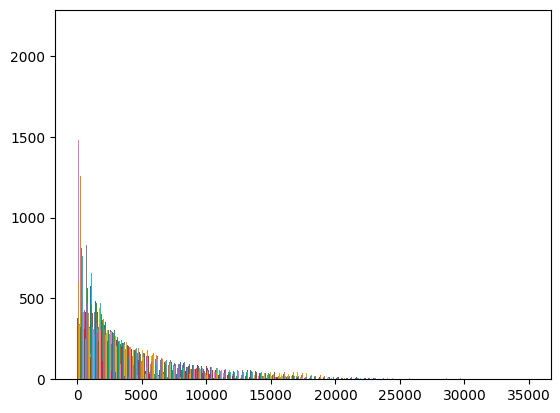

In [4]:
import numpy as np
import matplotlib.pyplot as plt
for i in range(5):
    path = "/vol/cs-hu/riabchuv/my_work/results/DE_96_24_loss_choice_for_DE_Informer_custom_ftM_sl96_ll5_pl24_dm512_nh8_el2_dl1_df2048_fc5_ebtimeF_dtTrue_lossMAE_Exp_0"
    pred = np.load(path + "/pred.npy")[:, :, i]
    true = np.load(path + "/true.npy")[:, :, i]
    errors = np.abs(pred - true)
    plt.hist(errors, bins=100)

In [2]:
import numpy as np
path = "/vol/cs-hu/riabchuv/my_work/results/DE_96_24_loss_choice_for_DE_Informer_custom_ftM_sl96_ll5_pl24_dm512_nh8_el2_dl1_df2048_fc5_ebtimeF_dtTrue_lossMAE_Exp_0"
np.load(path + "/true.npy")

array([[[5.3662000e+04, 7.6419637e-05, 3.2353000e+04, 5.6700000e+03,
         2.6683002e+04],
        [5.1976000e+04, 7.6419637e-05, 3.4308000e+04, 5.6310000e+03,
         2.8677000e+04],
        [5.0545000e+04, 7.6419637e-05, 3.6105000e+04, 5.7270000e+03,
         3.0378000e+04],
        ...,
        [6.4737000e+04, 7.6419637e-05, 3.9865000e+04, 3.7310000e+03,
         3.6134000e+04],
        [6.0686000e+04, 7.6419637e-05, 3.8528000e+04, 3.8740000e+03,
         3.4654000e+04],
        [5.6290000e+04, 7.6419637e-05, 3.8944000e+04, 4.0290000e+03,
         3.4914000e+04]],

       [[5.1976000e+04, 7.6419637e-05, 3.4308000e+04, 5.6310000e+03,
         2.8677000e+04],
        [5.0545000e+04, 7.6419637e-05, 3.6105000e+04, 5.7270000e+03,
         3.0378000e+04],
        [5.1018000e+04, 7.6419637e-05, 3.7279000e+04, 5.7960000e+03,
         3.1483002e+04],
        ...,
        [6.0686000e+04, 7.6419637e-05, 3.8528000e+04, 3.8740000e+03,
         3.4654000e+04],
        [5.6290000e+04, 7.641963

In [15]:
import numpy as np
a = np.array([[[1, 2], [3, 4]], [[5, 6], [7, 8]], [[9, 10], [11, 12]]])
a

array([[[ 1,  2],
        [ 3,  4]],

       [[ 5,  6],
        [ 7,  8]],

       [[ 9, 10],
        [11, 12]]])

In [23]:
# Feature 1
a[0, 0, 0]
# Feature 2
a[0, 0, 1]

2

In [19]:
shape = a.shape
shape
# B=3, L=2, C=2

(3, 2, 2)

In [20]:
a.reshape(shape[0] * shape[1], -1)

array([[ 1,  2],
       [ 3,  4],
       [ 5,  6],
       [ 7,  8],
       [ 9, 10],
       [11, 12]])

In [24]:
a.reshape(shape[0] * shape[1], -1).reshape(shape)

array([[[ 1,  2],
        [ 3,  4]],

       [[ 5,  6],
        [ 7,  8]],

       [[ 9, 10],
        [11, 12]]])